# 13. explainability

1. Train at least two advanced models on the energy dataset from TSA_Example notebook. You may choose to use only the last 5 years of the dataset to reduce data size
2. Explain the patterns the model has learned using SHAP local and global plots
3. Explain the patterns using LIME
4. Compare the answers from LIME & SHAP (global & some local) – what do you see? Is it the same?

In [1]:
import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tensorflow
from tensorflow import keras
from keras import layers
import shap
import lime
import lime.lime_tabular
from IPython.display import display, HTML

1. Train at least two advanced models on the energy dataset from TSA_Example notebook. You may choose to use only the last 5 years of the dataset to reduce data size

Loading data 

In [2]:
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")
print("Path to dataset files:", path)

files = os.listdir(path)
print(files)

Path to dataset files: C:\Users\abjar\.cache\kagglehub\datasets\robikscube\hourly-energy-consumption\versions\3
['AEP_hourly.csv', 'COMED_hourly.csv', 'DAYTON_hourly.csv', 'DEOK_hourly.csv', 'DOM_hourly.csv', 'DUQ_hourly.csv', 'EKPC_hourly.csv', 'est_hourly.paruqet', 'FE_hourly.csv', 'NI_hourly.csv', 'PJME_hourly.csv', 'PJMW_hourly.csv', 'pjm_hourly_est.csv', 'PJM_Load_hourly.csv']


limiting data to 5 years 

In [3]:
df = pd.read_csv(path + "/PJME_hourly.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])

last_5_years = df['Datetime'].max() - pd.DateOffset(years=5)
df = df[df['Datetime'] >= last_5_years]

print(f"Dataset shape after filtering: {df.shape}")
print(df.columns)

Dataset shape after filtering: (43823, 2)
Index(['Datetime', 'PJME_MW'], dtype='object')


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43823 entries, 96409 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Datetime  43823 non-null  datetime64[ns]
 1   PJME_MW   43823 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.0 MB


data formatting and feature engineering 

In [5]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

df['Year'] = df['Datetime'].dt.year
df['Month'] = df['Datetime'].dt.month
df['Day'] = df['Datetime'].dt.day
df['Hour'] = df['Datetime'].dt.hour 
df['DayOfWeek'] = df['Datetime'].dt.weekday
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int) 

df = df.set_index('Datetime')
df = df.sort_index()

print(df.head())


                     PJME_MW  Year  Month  Day  Hour  DayOfWeek  IsWeekend
Datetime                                                                  
2013-08-03 00:00:00  32081.0  2013      8    3     0          5          1
2013-08-03 01:00:00  29409.0  2013      8    3     1          5          1
2013-08-03 02:00:00  27455.0  2013      8    3     2          5          1
2013-08-03 03:00:00  26207.0  2013      8    3     3          5          1
2013-08-03 04:00:00  25442.0  2013      8    3     4          5          1


We extract useful time-based features (year, month, day, hour, weekday, weekend flag) from the Datetime column. These help the model learn seasonal and daily patterns in energy consumption. We also set Datetime as the index for proper time ordering.

We define our target variable (energy consumption in MW) and use the engineered time-based features as predictors.  
Instead of a random 80/20 split, we split chronologically: the first 80% of the data is used for training, and the last 20% is kept for testing.  
This ensures that the model is evaluated on future (unseen) data, which is important for time series forecasting.


In [6]:
TARGET = "PJME_MW"

df = df.sort_index()
split_idx = int(len(df) * 0.8)
train = df.iloc[:split_idx].copy()
test  = df.iloc[split_idx:].copy()

X_train = train.drop(columns=[TARGET])
y_train = train[TARGET]
X_test  = test.drop(columns=[TARGET])
y_test  = test[TARGET]

print("Train range:", train.index.min(), "→", train.index.max(), "| shape:", X_train.shape)
print("Test  range:", test.index.min(), "→", test.index.max(),  "| shape:", X_test.shape)


Train range: 2013-08-03 00:00:00 → 2017-08-02 19:00:00 | shape: (35058, 6)
Test  range: 2017-08-02 20:00:00 → 2018-08-03 00:00:00 | shape: (8765, 6)


We train an XGBoost regressor on the dataset. XGBoost is a tree-based boosting method that often performs well on structured/tabular data. After training, we evaluate it using MAE and MSE on the test set.

In [7]:
xgb_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"XGBoost - MAE: {mae_xgb:.4f}, MSE: {mse_xgb:.4f}")


XGBoost - MAE: 3450.3725, MSE: 21703061.3710


In [8]:
df.describe()

PJME_MW          Year         Month           Day          Hour  \
count  43823.000000  43823.000000  43823.000000  43823.000000  43823.000000   
mean   31312.417931   2015.586587      6.524291     15.727289     11.500057   
std     6319.626351      1.497120      3.448612      8.800130      6.922413   
min    19255.000000   2013.000000      1.000000      1.000000      0.000000   
25%    26909.000000   2014.000000      4.000000      8.000000      6.000000   
50%    30368.000000   2016.000000      7.000000     16.000000     12.000000   
75%    34973.500000   2017.000000     10.000000     23.000000     17.500000   
max    56609.000000   2018.000000     12.000000     31.000000     23.000000   

          DayOfWeek     IsWeekend  
count  43823.000000  43823.000000  
mean       2.999338      0.285832  
std        2.000359      0.451815  
min        0.000000      0.000000  
25%        1.000000      0.000000  
50%        3.000000      0.000000  
75%        5.000000      1.000000  
max        6.000000      1.000000

The XGBoost model achieves an MAE of about 3,450 MW and an MSE of about 21.7 million on the test set.  
Given that the average demand is around 31,000 MW (with a standard deviation of ~6,300 MW), this corresponds to roughly an 11% error relative to typical demand levels.  
This performance will serve as our baseline for comparison with other models.


We now train a neural network as our second model. The network has two hidden layers 
with ReLU activation, and we train it using mean squared error as the loss function. Performance is again 
evaluated on the test set using MAE and MSE.

Unlike tree-based models such as XGBoost, neural networks are sensitive to feature scaling.  
Therefore, we standardize the input features (`Year`, `Month`, `Day`, etc.) using `StandardScaler` before training.  
This ensures that all features have comparable magnitudes, which helps the optimizer converge faster and prevents the model from being biased toward features with larger values.

In [9]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

mlp_model = keras.Sequential([
    keras.Input(shape=(X_train_s.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

mlp_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

es = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = mlp_model.fit(
    X_train_s, y_train,
    epochs=100, batch_size=256,
    validation_data=(X_test_s, y_test),
    callbacks=[es],
    verbose=1
)

mlp_loss, mlp_mae = mlp_model.evaluate(X_test_s, y_test, verbose=0)
print(f"MLP - MAE: {mlp_mae:.1f}, MSE: {mlp_loss:.1f}")

Epoch 1/100
137/137 [==============================] - 0s 1ms/step - loss: 1022218304.0000 - mae: 31328.3672 - val_loss: 1007701184.0000 - val_mae: 31160.8105
Epoch 2/100
137/137 [==============================] - 0s 845us/step - loss: 1013801856.0000 - mae: 31193.2246 - val_loss: 990110976.0000 - val_mae: 30877.7109
Epoch 3/100
137/137 [==============================] - 0s 866us/step - loss: 982541760.0000 - mae: 30686.5371 - val_loss: 941129152.0000 - val_mae: 30076.3281
Epoch 4/100
137/137 [==============================] - 0s 831us/step - loss: 915289280.0000 - mae: 29567.8574 - val_loss: 851156864.0000 - val_mae: 28545.4551
Epoch 5/100
137/137 [==============================] - 0s 846us/step - loss: 807242368.0000 - mae: 27673.9531 - val_loss: 720196480.0000 - val_mae: 26155.1758
Epoch 6/100
137/137 [==============================] - 0s 860us/step - loss: 664295616.0000 - mae: 24944.7891 - val_loss: 560415168.0000 - val_mae: 22894.7715
Epoch 7/100
137/137 [========================

The MLP model achieves an MAE of about **5572 MW** and an MSE of about **47.3 million**.  
This is noticeably worse than XGBoost, which had an MAE of ~3450 MW and an MSE of ~21.7 million.  
Although neural networks are flexible and can approximate complex patterns, in this case the tree-based model clearly outperforms the MLP on our time-based features.


we though it was fun to compare the two models in how well they predict energy consumptions 

In [10]:
# use the scaled test features for the MLP
y_pred_mlp = mlp_model.predict(X_test_s).ravel()

# XGBoost uses raw features
y_pred_xgb = xgb_model.predict(X_test)

274/274 [==============================] - 0s 404us/step


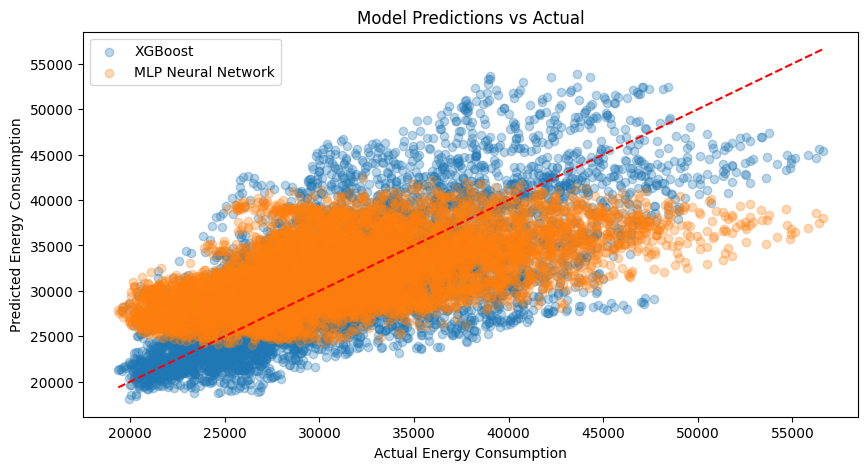

In [11]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred_xgb, alpha=0.3, label="XGBoost")
plt.scatter(y_test, y_pred_mlp, alpha=0.3, label="MLP Neural Network")
lims = [y_test.min(), y_test.max()]
plt.plot(lims, lims, 'r--')            # 45° line
plt.xlabel("Actual Energy Consumption")
plt.ylabel("Predicted Energy Consumption")
plt.legend()
plt.title("Model Predictions vs Actual")
plt.show()


To compare the performance of the two models, we plot predicted energy consumption against actual values.

The red dashed line represents the ideal case where predictions exactly match actuals.

XGBoost predictions (blue) cluster closer to the line, showing higher accuracy.

MLP predictions (orange) are more spread out, especially at higher consumption values, reflecting weaker performance.

This visualization makes it clear that XGBoost captures the demand patterns more effectively than the MLP in this setup.

### 2. Explain the patterns the model has learned using SHAP local and global plots

local shap plots for XGBoost

In [12]:
X_test_df = pd.DataFrame(X_test, columns=X_test.columns) 

explainer_xgb = shap.Explainer(xgb_model)

shap_values_xgb = explainer_xgb(X_test_df)

🔹 XGBoost - Local SHAP Explanation for Test Row 10:


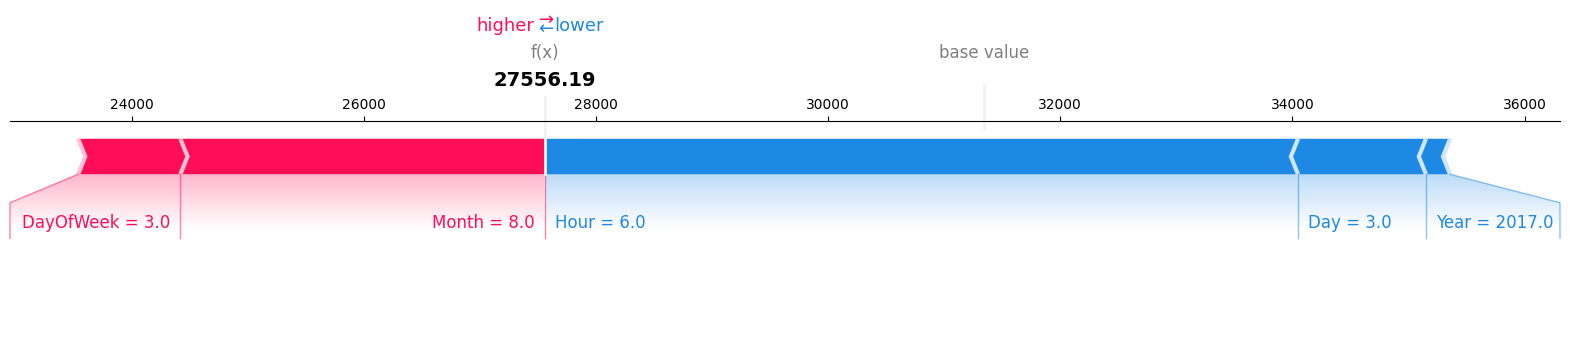

🔹 XGBoost - Local SHAP Explanation for Test Row 50:


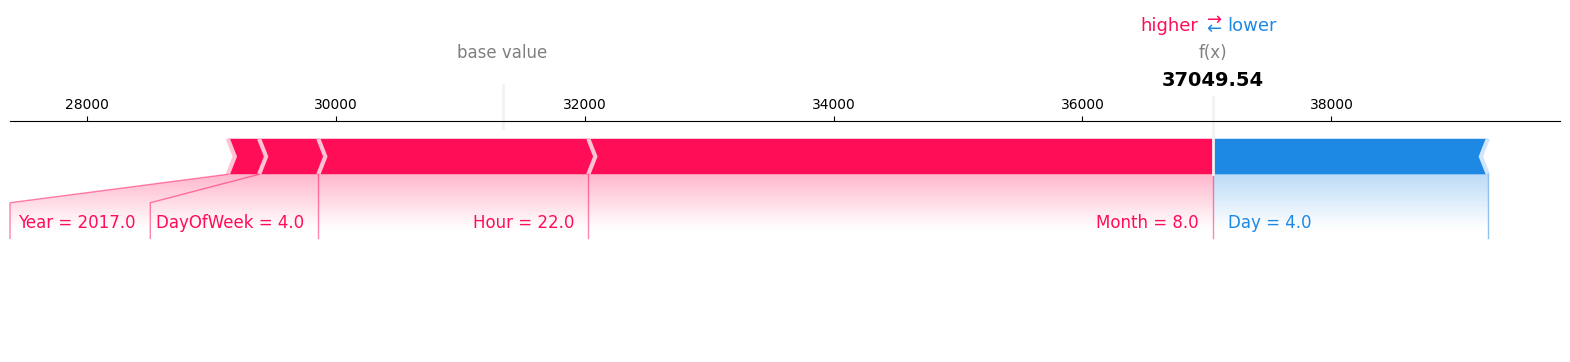

🔹 XGBoost - Local SHAP Explanation for Test Row 99:


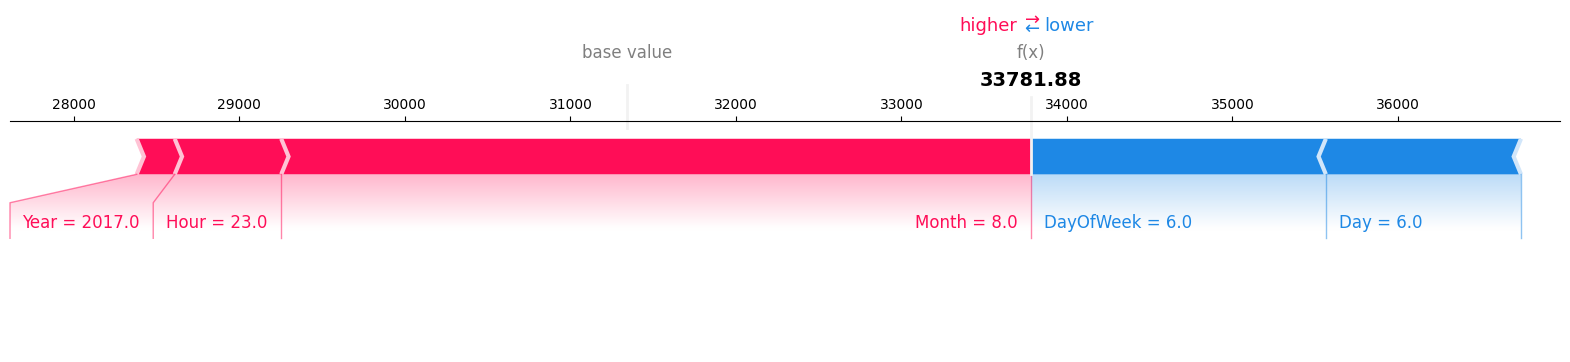

In [13]:
local_indices = [10, 50, 99]

for idx in local_indices:
    print(f"🔹 XGBoost - Local SHAP Explanation for Test Row {idx}:")
    
    shap_exp = shap.Explanation(
        values=shap_values_xgb[idx], 
        base_values=explainer_xgb.expected_value, 
        data=X_test_df.iloc[idx], 
        feature_names=X_test_df.columns
    )

    shap.force_plot(shap_exp.base_values, shap_exp.values, shap_exp.data, feature_names = shap_exp.feature_names, matplotlib=True)
    plt.show()

looking at the local shap explanation for row 10, the energy consumption is lower. you can see that the time of day is having the largest effect on the energy consumption in this case, this could be because it is early morning.

on the second plot where row 50 is explained, we can see that that largest impact comes from the month being around september. looking at the hour it is more insignificant in this case.

looking at the last plot for row 99, we can see that it is the month that affects the energy consumption the most by raising it. hour is not as important for the total energy consumption in this case

Global SHAP plot for XGboost

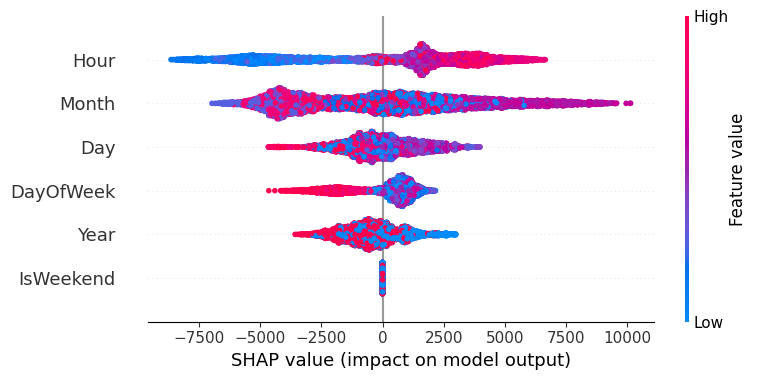

In [14]:
shap.summary_plot(shap_values_xgb, X_test_df)


looking at the plot, xgboost captures clear trends in timebased effects on energy usage looking at the hour(which is the most important), then we can see that when the hour value is low, then the energy consumption is low, and when its high then the energy consumption is high.

on the plot, we can see the month feature is the second most important, though the distribution seems a bit more random. this could maybe be the reason why the months seem so random in the local tests. this could be affected by some external event.  

we notice that in 2 of 3 local tests the hour feature has a lower impact on overall consumption when the global test shows that it affects the most. though month is at a close second

In [15]:
def mlp_predict(data):
    return mlp_model.predict(data).flatten() 

explainer_mlp = shap.KernelExplainer(mlp_predict, X_train_s[:100])  

# only running small test size to avoid long runtime
shap_values_mlp = explainer_mlp.shap_values(X_test_s[:100], silent = True)

94/94 [==============================] - 0s 409us/step


🔹 MLP - Local SHAP Explanation for Test Row 10:


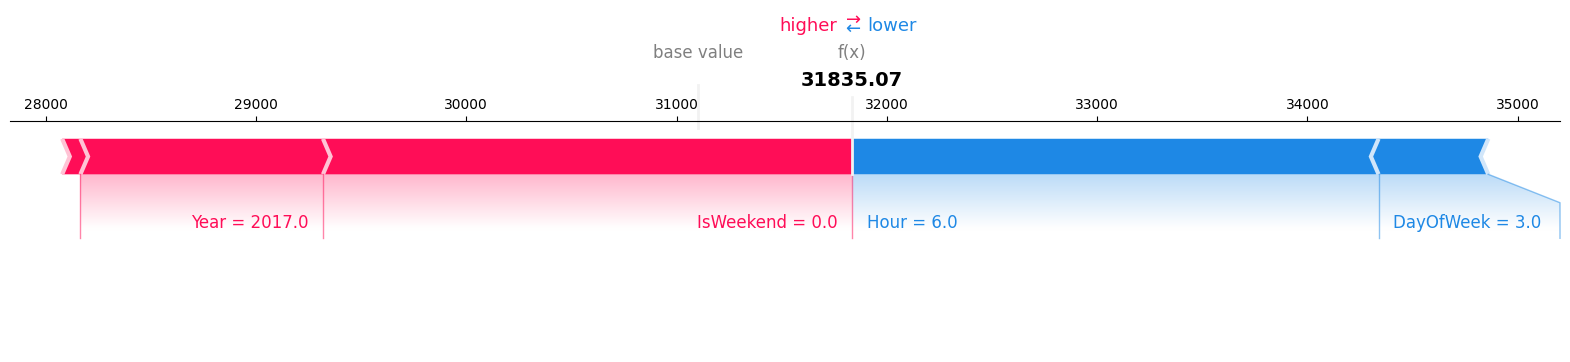

🔹 MLP - Local SHAP Explanation for Test Row 50:


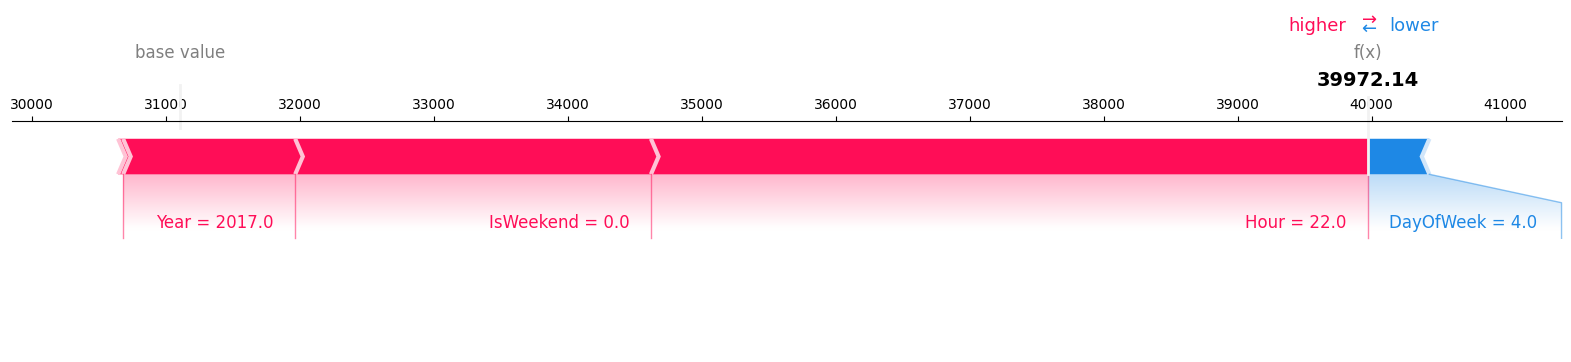

🔹 MLP - Local SHAP Explanation for Test Row 99:


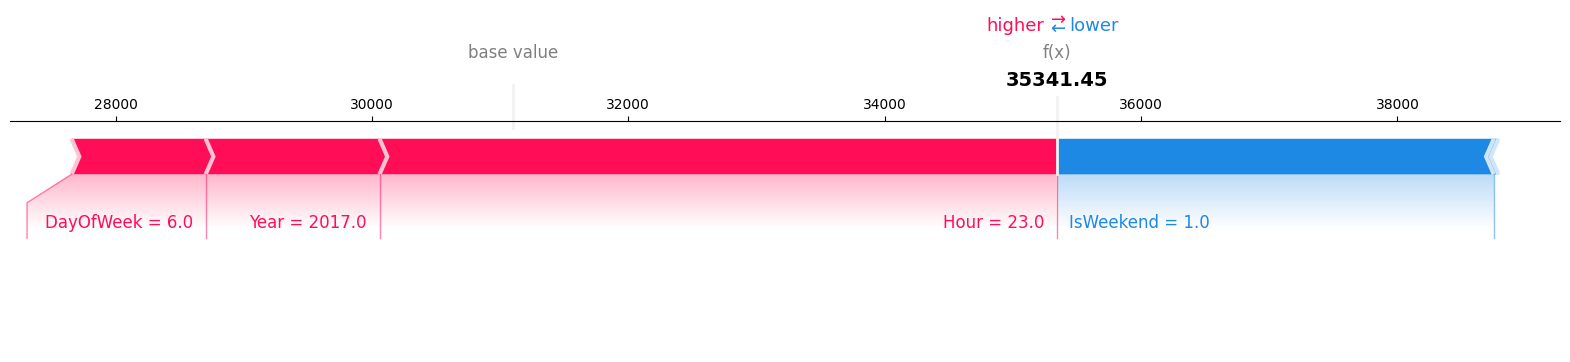

In [16]:
local_indices = [10, 50, 99]

for idx in local_indices:
    print(f"🔹 MLP - Local SHAP Explanation for Test Row {idx}:")
    
    shap_exp = shap.Explanation(
        values=shap_values_mlp[idx], 
        base_values=explainer_mlp.expected_value, 
        data=X_test_df.iloc[idx], 
        feature_names=X_test_df.columns
    )

    shap.force_plot(shap_exp.base_values, shap_exp.values, shap_exp.data, feature_names = shap_exp.feature_names, matplotlib=True)
    plt.show()


looking at the local SHAP tests from MLP, the one from row 10 is affected equally by, hour, IsWeekend and year. day of week seem to have a small effect on the energy consumption. 

for the second local SHAP test we can see that the hour being 22 affects the energy consumption by the largest amount, this is different compared to the SHAP test from XGBoost where month affects the most. it seems that MLP predicts that the consumption will be higher and that the largest factor is the hour of the day.

lastly we have explanation for row 99, where hour has the largest impact on the energy consumption. whough year and IsWeekend are not too far behind. and both are equal. 

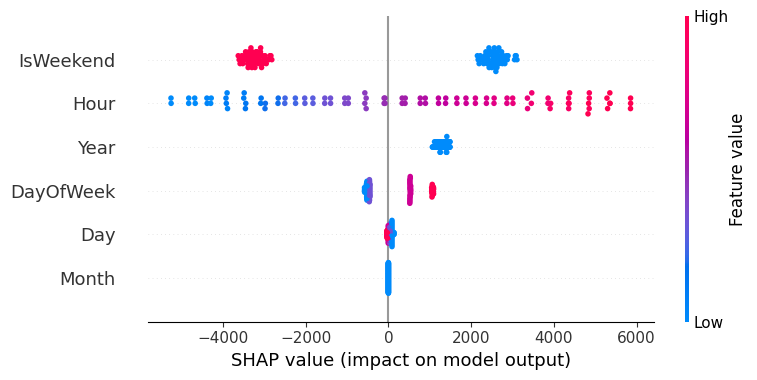

In [17]:
X_test_df = pd.DataFrame(X_test[:100], columns=X_test.columns)

shap.summary_plot(shap_values_mlp, X_test_df)

since the shap kernel has some limitations, it is a bit harder to discern the tendencies.

MLP deems the weekend feature more important. the time of day is second in importance. MLP chooses different features than XGBoost, especially the month feature, where MLP weights it the lowest. 

looking at the impacts on model output we can see that MLP clearer view on whether high or low values impact on energy consumption. here the values in XGBoost seemed a bit more random at times 

3. Explain the patterns using LIME

In [18]:

X_test = pd.DataFrame(X_test, columns=X_test.columns)
explainer_lime_xgb = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_s), 
    feature_names=X_test.columns, 
    mode='regression'
)

we have to render the LIME with HTML since we are working with VScode in darkmode, otherwise we cant read the tests.

In [19]:

local_indices = [10, 50, 100]

for idx in local_indices:
    print(f"\n🔹 **LIME Explanation for XGBoost - Test Row {idx}**")

    exp_xgb = explainer_lime_xgb.explain_instance(
        data_row=X_test.iloc[idx], 
        predict_fn=xgb_model.predict, 
        num_features=5  
    )

    # render the lime with white background for readability
    html_xgb = exp_xgb.as_html()
    display(HTML(f'<div style="background-color:white;">{html_xgb}</div>'))



🔹 **LIME Explanation for XGBoost - Test Row 10**


c:\Users\abjar\AppData\Local\Programs\Python\Python310\lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\abjar\AppData\Local\Programs\Python\Python310\lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\abjar\AppData\Local\Programs\Python\Python310\lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always 


🔹 **LIME Explanation for XGBoost - Test Row 50**


c:\Users\abjar\AppData\Local\Programs\Python\Python310\lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\abjar\AppData\Local\Programs\Python\Python310\lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\abjar\AppData\Local\Programs\Python\Python310\lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always 


🔹 **LIME Explanation for XGBoost - Test Row 100**


c:\Users\abjar\AppData\Local\Programs\Python\Python310\lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\abjar\AppData\Local\Programs\Python\Python310\lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\abjar\AppData\Local\Programs\Python\Python310\lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always 

in the first lime plot, the model predicts low energy usage. in the row it is early morning during a weekend during the end of the year. here hour has the highest impact, probably because it is early morning. 

in the second plot, the model predicts a higher energy consumption due to evening peak hours. the month has the second highest impact.

in the third plot, we can see that the hour again has the largest impact on energy prediction. secondly the month affects our value in a positive way. 

In [20]:
def mlp_predict_unscaled(arr):
    df = pd.DataFrame(arr, columns=X_train.columns)
    arr_scaled = scaler.transform(df)
    return mlp_model.predict(arr_scaled).ravel()

explainer_lime_mlp = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    mode='regression',
    discretize_continuous=True,
    random_state=42
)

local_indices = [10, 50, 99]
for idx in local_indices:
    print(f"\n🔹 LIME Explanation for MLP — Test Row {idx}")
    exp_mlp = explainer_lime_mlp.explain_instance(
        data_row=X_test.iloc[idx].values,
        predict_fn=mlp_predict_unscaled,
        num_features=5
    )
    display(HTML(f'<div style="background-color:white;">{exp_mlp.as_html()}</div>'))

NameError: name 'lime_tabular' is not defined

in the first test, MLP predicts its energy consumption mostly based on whether it is a weekend and the hour of the day. in this case, it being a weekday has the largest impact, and secondly it being early morning also impacts but in a negative way.

in the second test, a higher energy consumption is predicted by MLP, this is probably due to evening peak usage on a weekday. Month slightly reduce the prediction, though not enough to offset peak hour effects

in the third test the model predicts high energy as well. here it is a weekend which has the highest impact and has a negative impact overall. though it seems that the other features has enough of an impact to counteract the negative effect of it being a weekend. 

4. Compare the answers from LIME & SHAP (global & some local) – what do you see? Is it the same?

in the global explanation in SHAP, XGBoost indicates that Hour, Month and DayOfWeek have the most significant impact on predictions, with Hour having the widest range of SHAP values. MLP has fewer datapoints(due to limits of SHAP kernel) though Hour is still important, the most important for MLP is IsWeekend. as we stated earlier, MLP deems month to be the least impactful overall. SHAP consistently show us that Hour is the strongest predictor in both models,. though XGBoost and MLP are very different on the impacts of the features IsWeekend and Month. 

in only 1 of 6 local XGBoost tests(both SHAP and LIME), Hour has the largest impact on the energy consumption which does not follow the global explanation. in all the LIME tests it is day of the week which is the most impactful feature. 

for the MLP test, it is either the IsWeekend feature, or the Hour. this also aligns with the global SHAP explanation.